<span style="font-size:12px;">

#### DNN CNN
- 독립적인 정보  
- 입력(x)간의 순서나 연관성을 고려하지 않는다  
#### 시계열 : 시간의 연속적인 흐름
- 시계열 데이터 : 날씨, 주식, 문장 -> 순서가 중요한 데이터  
#### RNN  
- 순환하는 구조   
    - 시점1 (월요일) : 맑음(x1) 정보가 RNN에 들어온다 -> RNN 날씨가 맑았음(h1) 이라는 요약본을 만듦  
    - 시점2 (화요일) : 흐림(x2) ->  RNN에 새로운 정보 (흐림, x2) + 어제의기억(맑았음 , h1)이라는 내용을 함께 고려   
        -> 어제는 맑았으나 오늘은 흐림이라는 새로운 h2 요약본을 생성  
    - 시점3 (수요일) : 비(x3) -> RNN에 새로운 정보 (비, x3) + 어제의 기억(어제 맑았는데 오늘 흐림 h2)  
        -> 새로운 상태 h3  
    - 반복  
- 알고리즘  
    - 각 시점(time setp)에서 1. 현재의 입력과 2. 과거의 기억(hidden state ht-1)을 함께 받아 3. 현재의 결과물과 4. 다음 시점으로 넘겨줄 최신기억 ht를 생성  
    - ht 기억이 시계열 데이터의 맥락(context)을 저장하는 역할  
- 장점  
    - 순서가 있는 데이터의 맥락을 학습  
- 한계  
    - 기억력이 생각보다 짧다  
    - 이전 정보가 소실되거나 반대로 너무 강해져서 폭주하여 제대로 학습이 안됨  
    - 시계열 데이터가 길어지면(예 100단계 전의 정보)  
    <span style="color: yellow;"> => 장기 기억 의존성 문제 (long-term dependency problem)  </span>

##### LSTM & GRU  
   - LSTM(long short term memory) : RNN 내부에 게이트(gate) 복잡한 장치 -> 잊고 기억할 정보를 관리   
   - GRU(gated recurrent unit) : LSTM 구조를 좀 더 단순화시킨 모델, LSTM과 성능은 비슷하며 속도는 빠르다

#### RNN 핵심수식
   - 은닉상태 계산
       - h1 = tanh(wht-1 + wxt - bh)
       - tanh : 값을 -1~1 사이로 변경해주는 활성화함수
       - wht-1 : 과거기억
       - wht : 현재의 정보
       - b : 가중치
       </span>

In [ ]:
url = 'https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv'
# url2 = 'https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_test.csv'
import pandas as pd
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [8]:
# 전체 데이터셋 확인
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


,Open,High,Low,Volume,Close
count,967.000000,967.000000,967.000000,9.670000e+02,967.000000
mean,223.923475,227.154085,220.323681,9.886233e+06,223.827301
std,104.455030,106.028484,102.549658,6.467710e+06,104.319356
min,81.000000,85.000000,80.000000,1.616300e+06,83.000000
25%,124.000000,126.000000,123.000000,5.638150e+06,124.000000
50%,194.000000,196.000000,192.000000,8.063300e+06,194.000000
75%,329.000000,332.000000,323.000000,1.198440e+07,327.500000
max,421.000000,423.000000,413.000000,5.841040e+07,419.000000


In [ ]:
# EDA - 탐색적 데이터 분석

In [2]:
# 데이터셋 정의
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
class StockDataSet(Dataset):
    def __init__(self):
        url = 'https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv'
        self.csv = pd.read_csv(url)
        data = self.csv.iloc[:, 1:-1].values
        label = self.csv.iloc[:,-1].values.reshape(-1,1)    # # reshape의 배열을 바꾸는 것
        self.data =  StandardScaler().fit_transform(data)  # 입력데이터(피처). 범위의 정규화
        # 정답이 숫자가 크다면 정규화가 학습에 도움이 된다.
        self.label = StandardScaler().fit_transform(label) # 정답데이터(레이블)
        self.data = torch.Tensor(self.data)
        self.label = torch.Tensor(self.label)

    def __len__(self):
        return len(self.data) - 30      # 사용가능한 배치의 개수. 30일치의 데이터를 잘라서 확인/ 마지막 30을 빼는 이유는 마지막 값은 예측값이 없기 때문
    def __getitem__(self, index):       # 데이터셋에서 특정 index에 해당하는 샘플 한개를 어떻게 만들지에 대한 내용
        data = self.data[index:index+30]        # 0~29번까지의 데이터 / +30인 이유는 처음에는 비어있기 떄문에 비교할 값이 없어서 30일치를 채워준다
        label= self.label[index + 30]       # 30번 데이터(31일째값) -> 이 30일치 데이터를 보고 다음날의 값을 맞춰봐라는 의미
        return data, label


In [19]:
# 테스트
dataset = StockDataSet()
sample_data, sample_label = next(iter(dataset))
sample_data
sample_label

tensor([-1.2452])

In [4]:
import torch.nn as nn
class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN,self).__init__()
        # (30일, 배치16개, 각 입력의 특성 4개) batch_first = False  
        # (배치 16개, 30일 각 입력의 특성 4개) batch_first = True       
        # batch_first=True: 이 설정을 통해 데이터의 차원 순서를 (배치 크기, 시퀀스 길이, 피처 개수) 즉, (16, 30, 4) 형태로 다룰 수 있습니다. 이게 False일 경우 (30, 16, 4)가  됨
        self.rnn = nn.RNN(input_size=4, hidden_size=8,num_layers=5, batch_first=True)       # num_layers은 깊이
        # 출력 (batch, 30, 8 ) -> 30일치 매번 8개씩 반환(히든사이즈가 8)
        self.fc1 = nn.Linear(30*8,64) # RNN을 출력 받아 처리할 첫번쨰 일반 신경망층
        self.fc2 = nn.Linear(64,1)
        self.relu = nn.ReLU()
    
    def forward(self,x,ho): # 실제 데이터 처리 과정
        # 입력데이터는 (16,30,4)
        # ho는 초기 은닉상태 (num_layer, batch, hidden size) (5,16,8)
        # 출력 x는 모든 시점에 대한 hidden_out을 담고 있어야 한다 (batch,seq_len,hidden_size) (16,30,8)     
        # 출력 hn 최종은닉상태(각레이어의 마지막 타임스템프 hidden state) (num_layer,batch,hidden_sate)(5,16,8)
        x,hn = self.rnn(x,ho)
        # mlp 입력으로 사용될 수 있도록 모양 변경
        x = torch.reshape(x,(x.shape[0],-1))

        # mlp
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        # 예측한 종가 1차원 벡터
        out= torch.flatten(x)
        return out

        

In [5]:

rnn = StockRNN()
sample_data = torch.randn(16,30,4 )
# 초기 hidden state 값  (num_layer, batch_size, hidden_size)  (5,16,8)
ho = torch.zeros(5,16,8)
out = rnn(sample_data,ho)
out.size()

torch.Size([16])

In [6]:

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StockRNN().to(device)
dataset = StockDataSet()
loader = DataLoader(dataset,batch_size=16)
optim = Adam(model.parameters(), lr=1e-3)

In [9]:

data,label = next(iter(loader))
data.dtype, label.dtype

(torch.float32, torch.float32)

In [10]:
# Expected hidden size (5, 9, 8), got [5, 16, 8]
# Rnn이 처리하는 배치크기는 9  우리가 설계한 ho 16
print(len(dataset) % 25)
# 마지막 배치가 개수가 모라자서 9

12


In [ ]:

from tqdm import tqdm
# criterian = nn.MSELoss()
for epoch in range(200):
    loop = tqdm(loader)
    for data, label in loop:
        optim.zero_grad()        # 초기 은닉상태의 배치크기는 DataLoader가 주는 배치 크기
        batch_size = data.size(0)

        ho = torch.zeros(5,batch_size,8).to(device)  # (5,batch_size,8) 이 형식에 값은 0인 토치를 만든다.즉 값을 0으로 채운 초기값을 생성해줌x
        # 모델의 예측값
        pred = model(data.to(device), ho)
        # 손실값
        loss = nn.MSELoss()(pred, label.to(device))
        loss.backward()
        optim.step()

        loop.set_description(f'epoch:{epoch+1} loss:{loss.item()}')
torch.save(model.state_dict(), './rnn.pth')

epoch:200 loss:0.038637787103652954: 100%|██████████| 937/937 [00:21<00:00, 44.40it/s]  


In [59]:

# 모델 성능평가하기
import matplotlib.pyplot as plt

loader = DataLoader(dataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
    model.load_state_dict(torch.load('rnn.pth', map_location=device,weights_only=False))
    for data, label in loader:
        # 초기 은닉상태의 배치크기는 DataLoader가 주는 배치 크기
        batch_size = data.size(0)

        ho = torch.zeros(5,batch_size,8).to(device)
        # 모델의 예측값
        pred = model(data.to(device), ho)
        preds.append(pred.item())
        # 손실값
        loss = nn.MSELoss()(pred, label.to(device))
        total_loss += (loss.item() / len(loader))

print(f'total_loss : {total_loss:.4f}')


c:\Users\SAMSUNG\anaconda3\envs\deep\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_loss : 0.0369


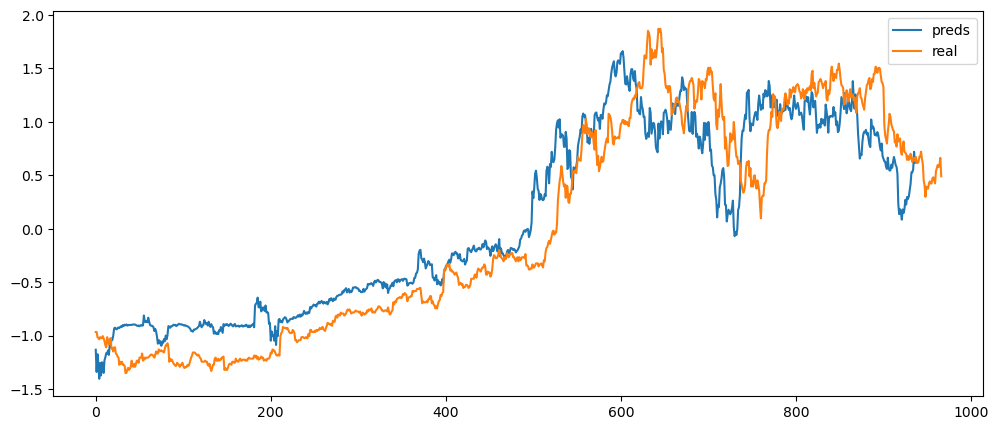

In [62]:
plt.figure(figsize=(12,5))
plt.plot(preds, label = 'preds')
plt.plot(dataset.label, label = 'real')
plt.legend()
plt.show() 

### 31일날 예측하기

In [63]:
with torch.no_grad():
    last_30 = df.iloc[-30:,1:-1].values
    X = torch.tensor(last_30,dtype=torch.float32).unsqueeze(0)
    # (num_layer, batch, hidden)
    ho = torch.zeros(5,1,8).to(device)    
    pred = model(X.to(device),ho)
    print(pred.item())

0.13340821862220764


-> 값이 작은 이유는 정규화를 해줬기 때문.  
-> 정규화한 값을 다시 원래 값으로 돌린다

In [ ]:
# yfinance
X = np.array([
    [10,20],[100,200]
])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

In [ ]:

scaler.inverse_transform(X_scaled)